In [15]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [16]:
# архитектура модели + 
# загрузчик данных +
# формирование батча +
# инициализировать модель +
# оптимизатор +
# функция потерь +
# опционально шедулеры -
# трейн луп

In [17]:
dataset = datasets.MNIST('.', download=True)


In [18]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

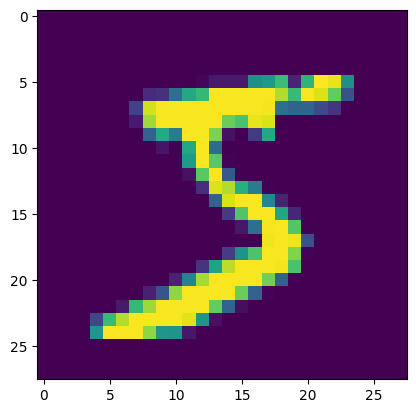

In [19]:
import matplotlib.pyplot as plt

plt.imshow(dataset.data[0].detach().numpy())
plt.show()

In [20]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        # custom initsialisation nn.init.xavier_normal_(self.linear1.weight)
        self.do1 = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.linear2(x)

        return x

In [21]:
# Как формируется батча
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset

def collate_fn(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1), # B x 7xx преобразуем матрицу 28х28 в вектор 7хх
      'target': target,
      }


In [22]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:1' id GPU
n_epochs = 10
batch_size = 128

In [23]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
model.train() 
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()


In [24]:
for epoch in range(n_epochs):
    dataloader = DataLoader(dataset, 
                            batch_size, 
                            shuffle=True, 
                            collate_fn=collate_fn,
                            drop_last = True,
                            )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')


epoch: 0, step: 0, loss: 2.3105058670043945
epoch: 0, step: 200, loss: 0.254281222820282
epoch: 0, step: 400, loss: 0.14785243570804596
epoch: 1, step: 0, loss: 0.1985655575990677
epoch: 1, step: 200, loss: 0.2335706651210785
epoch: 1, step: 400, loss: 0.21962063014507294
epoch: 2, step: 0, loss: 0.16681675612926483
epoch: 2, step: 200, loss: 0.0773339495062828
epoch: 2, step: 400, loss: 0.09033972769975662
epoch: 3, step: 0, loss: 0.11681797355413437
epoch: 3, step: 200, loss: 0.07534196227788925
epoch: 3, step: 400, loss: 0.10207383334636688
epoch: 4, step: 0, loss: 0.08057756721973419
epoch: 4, step: 200, loss: 0.0847630649805069
epoch: 4, step: 400, loss: 0.048682425171136856
epoch: 5, step: 0, loss: 0.07060776650905609
epoch: 5, step: 200, loss: 0.04531165212392807
epoch: 5, step: 400, loss: 0.07950525730848312
epoch: 6, step: 0, loss: 0.068268783390522
epoch: 6, step: 200, loss: 0.05128316208720207
epoch: 6, step: 400, loss: 0.037788014858961105
epoch: 7, step: 0, loss: 0.0334456

# Новый раздел

In [25]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
    # уменьшит размер картинки в 2 раза
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=2)
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.conv3 = nn.Conv2d(hidden_ch, 5, kernel_size=3, padding=1, stride=1) 
    self.classifier = nn.Linear(5 * 14 *14, output_dim)
    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)

    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation(x)
    x = self.do1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)
    x = self.do2(x)
    x = self.conv3(x)
    x = self.classifier(x.view(x.size(0), -1))

    return x

In [26]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [27]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [28]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [29]:
for epoch in range(n_epochs):
    dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model_conv(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')


epoch: 0, step: 0, loss: 2.298809766769409
epoch: 0, step: 200, loss: 0.03684588149189949
epoch: 0, step: 400, loss: 0.04090270772576332
epoch: 1, step: 0, loss: 0.07532734423875809
epoch: 1, step: 200, loss: 0.03585954010486603
epoch: 1, step: 400, loss: 0.08567873388528824
epoch: 2, step: 0, loss: 0.021028630435466766
epoch: 2, step: 200, loss: 0.013913503848016262
epoch: 2, step: 400, loss: 0.01604723185300827
epoch: 3, step: 0, loss: 0.013998869806528091
epoch: 3, step: 200, loss: 0.04064944386482239
epoch: 3, step: 400, loss: 0.037011757493019104
epoch: 4, step: 0, loss: 0.01414224412292242
epoch: 4, step: 200, loss: 0.024184439331293106
epoch: 4, step: 400, loss: 0.0050512137822806835
epoch: 5, step: 0, loss: 0.015678254887461662
epoch: 5, step: 200, loss: 0.04629480093717575
epoch: 5, step: 400, loss: 0.09727895259857178
epoch: 6, step: 0, loss: 0.04113507643342018
epoch: 6, step: 200, loss: 0.008822653442621231
epoch: 6, step: 400, loss: 0.023720698431134224
epoch: 7, step: 0, 